In [189]:
%matplotlib inline

import itertools
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from bambi import Model
import pymc3 as pm
from scipy.stats import zscore
from sklearn import model_selection
from sklearn.metrics import roc_curve, roc_auc_score
import tabulate

## Functions for prediction and cross-validation

Note: the prediction method I use here is not efficient and is a bit of a kludge

In [2]:
def get_terms(trace):
    terms = trace.varnames
    exclude = ['_sd_log__', '_offset', '_sd']
    for e in exclude:
        terms = [t for t in terms if t[-len(e):] != e]
    return terms

In [3]:
def get_group_id_index(result, varname, group_id):
    varname_group_string = f"{varname}[{group_id}]"
    return result.level_dict[varname].index(varname_group_string)

In [4]:
def get_weights(result, trace, varnames, group_dict=None):
    weights = []
    for v in varnames:
        if '|' not in v:
            weights.append(trace.get_values(v).mean())
        else:
            group_name = v.split('|')[1]
            group_id = group_dict[group_name]
            group_id_index = get_group_id_index(result, v, group_id)
            weights.append(trace.get_values(v)[:, group_id_index].mean())
    return weights

In [5]:
def df_add_term_cols(df, terms):
    """Appends interaction columns to a Pandas dataframe specified by terms. 
    
    When creating new columns, converts bool series to int. Returns new dataframe.
    """
    new_df = df.copy()
    terms = [t for t in terms if '|' not in t]
    terms = [t for t in terms if t != 'Intercept']
    terms = [t for t in terms if t[0:2] != '1|']

    for term in terms:
        col_names = term.split(':')
        
        # Create interaction term column
        if len(col_names) > 1:
            series = [new_df[col_name] for col_name in col_names]
            for i, s in enumerate(series):
                if s.dtype == bool:
                    series[i] = series[i].astype(int)
            new_df[term] = np.prod(np.array(series).T, axis=1)
    return new_df

In [6]:
def invlogit(x): return 1 / (1 + np.exp(-x))

In [26]:
def predict(row, terms, result, trace):
    subID = row['subID']
    weights = get_weights(result, trace, terms, {'subID': subID})
    terms_fixed = [t for t in terms if '|' not in t]    
    
    # Separate fixed and random effects, then adjust fixed effects weights by adding
    # random effects offsets
    w = np.array([weights[0:int(len(weights)/2)], weights[int(len(weights)/2):]]).sum(axis=0)
    x = np.hstack([1, row[terms_fixed[1:]].as_matrix()])
    prob = invlogit(np.sum(x * w))
    return prob

In [23]:
def bambi_cv(df, model_string, model_dict, 
             n_splits=5, dv='highArousal', grouping_var='subID'):
    fold_acc = []
    fold_results = []
    fold_models = []
    fold_roc = []
    fold_auc = []

    cv = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True)

    for train_ix, test_ix in cv.split(df, df[grouping_var]):
        m = Model(df.loc[train_ix, :])
        r = m.fit(
            model_string, **model_dict
        )

        terms = get_terms(m.backend.trace)
        #df_sm = df.loc[:, ['subID', 'bin', 'areaRatio', 'boundingBoxArea', 'highArousal']]
        df_sm_ex = df_add_term_cols(df, terms)
        df_sm_ex_test = df_sm_ex.loc[test_ix, :]

        probs = []
        for _, row in df_sm_ex_test.iterrows():
            probs.append(predict(row, terms, r, m.backend.trace))
        preds = np.array(probs) > 0.5

        df_sm_ex_test['pred'] = preds

        fold_roc.append(roc_curve(df_sm_ex_test[dv], probs))
        fold_auc.append(roc_auc_score(df_sm_ex_test[dv], probs))
        fold_acc.append(np.mean(df_sm_ex_test['pred'] == df_sm_ex_test[dv]))
        fold_results.append(r)
        fold_models.append(m)
        
    return (fold_acc, fold_results, fold_models, fold_roc, fold_auc)

## Functions for plotting

In [9]:
from logistic import plot_roc_cv

/usr/local/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [159]:
def plot_fixed(param, summary_df, data_df, steps=100, 
               x_label=None, y_label=None, title=None, ax=None):
    sns.set_style('ticks')
    sns.set_palette('muted')
    
    fsize = 14
    titlesize = 18

    x_min = data_df[param].min()
    x_max = data_df[param].max()
    
    summary_param = param
        
    if type(x_min) is bool or type(x_min) is np.bool_:
        x_min = float(x_min)
        x_max = float(x_max)
        summary_param += '[T.True]'
    
    slope_mean = summary_df.loc[summary_param]['mean']
    slope_lower = summary_df.loc[summary_param]['hpd0.95_lower']
    slope_upper = summary_df.loc[summary_param]['hpd0.95_upper']

    i_mean = summary_df.loc['Intercept']['mean']
    i_lower = summary_df.loc['Intercept']['hpd0.95_lower']
    i_upper = summary_df.loc['Intercept']['hpd0.95_upper']

    xs = np.linspace(np.floor(x_min), np.ceil(x_max), steps)

    X = np.hstack([np.array([1] * len(xs))[:,None],
                   xs[:,None]])
    yhat = invlogit(np.dot(X, np.vstack([i_mean, slope_mean]))).T[0]
    yhat_lower = invlogit(np.dot(X, np.vstack([i_lower, slope_lower]))).T[0]
    yhat_upper = invlogit(np.dot(X, np.vstack([i_upper, slope_upper]))).T[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,5))
    
    ax.tick_params(labelsize=fsize)
    
    ax.plot(xs, yhat, color='black')
    ax.fill_between(xs, yhat_upper, yhat_lower, color="gray", alpha=0.4)
    
    if x_label is None:
        x_label = param
    if y_label is None:
        y_label = f"p(highArousal | {param})"
        
    ax.set_xlabel(x_label, fontsize=fsize)
    ax.set_ylabel(y_label, fontsize=fsize)
    
    if title is not None:
        ax.set_title(title, fontsize=titlesize)
    
    sns.despine(bottom=True, left=True)

In [89]:
def plot_full_cv(fold_results, fold_roc, param, data_df, 
                x_label=None, y_label=None, title=None):
    f = plt.figure(figsize=(10,3))
    plt.subplots_adjust(wspace=0.45)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    summary_dfs = [res.summary() for res in fold_results]
    df_concat = pd.concat(summary_dfs)
    mean_df = df_concat.groupby(df_concat.index).mean()
    
    plot_fixed(param, mean_df, data_df, x_label=x_label, y_label=y_label, title=title, ax=ax0)
    plot_roc_cv(fold_roc, display_cv_folds=False, ax=ax1)

## Table generation

In [203]:
table_headers = ['M', 'SD', 'CI lower', 'CI upper', 'Effective N', 'Gelman-Rubin']

In [208]:
def summary_table(results):
    all_summaries = [res.summary() for res in results]
    all_summaries_concat = pd.concat(all_summaries)
    all_summaries_mean = all_summaries_concat.groupby(all_summaries_concat.index).mean().round(2)
    table = tabulate.tabulate(
        all_summaries_mean,
        headers=table_headers, 
        tablefmt='pipe'
    ).replace('|subID', '\|subID').replace('[T.True]', '')
    return table

## Load data

In [145]:
neg = pd.read_csv('../data/study_3/negative.csv')
pos = pd.read_csv('../data/study_3/positive.csv')
merged = neg.append(pos, ignore_index=True)

In [146]:
merged['subID'].value_counts()

47    520
52    520
39    520
23    520
7     520
54    520
38    520
53    520
37    520
35    520
31    520
19    520
50    520
34    520
18    520
17    520
1     520
32    520
55    520
8     520
40    520
27    520
15    520
46    520
14    520
29    520
28    520
12    520
56    520
43    520
11    520
42    520
26    520
57    520
41    520
16    520
59    416
44    286
22    156
10    156
Name: subID, dtype: int64

In [148]:
init_len_neg = neg.shape[0]
neg = neg.drop(neg[neg['rating'] == 'INAUDIBLE'].index)
dropped_neg = init_len_neg - neg.shape[0]
neg = neg.reset_index(drop=True)
print(f"Dropped {dropped_neg} rows from neg due to 'INAUDIBLE'. Final shape: {neg.shape}")

init_len_pos = pos.shape[0]
pos = pos.drop(pos[pos['rating'] == 'INAUDIBLE'].index)
dropped_pos = init_len_pos - pos.shape[0]
pos = pos.reset_index(drop=True)
print(f"Dropped {dropped_pos} rows from pos due to 'INAUDIBLE'. Final shape: {pos.shape}")

Dropped 73 rows from neg due to 'INAUDIBLE'. Final shape: (9989, 12)
Dropped 31 rows from pos due to 'INAUDIBLE'. Final shape: (9641, 12)


In [149]:
pos['modalitySound'] = pos['stimType'] == 'sound'
neg['modalitySound'] = neg['stimType'] == 'sound'

vis_neg = neg[neg['stimType'] == 'image']
aud_neg = neg[neg['stimType'] == 'sound']
vis_pos = pos[pos['stimType'] == 'image']
aud_pos = pos[pos['stimType'] == 'sound']

merged = neg.append(pos, ignore_index=True)
merged['highArousal'] = ((merged['rating'] == 'Angry') | (merged['rating'] == 'Excited')).astype(bool)
merged['positiveValence'] = ((merged['rating'] == 'Excited') | (merged['rating'] == 'Peaceful')).astype(bool)
#merged = pd.get_dummies(merged, columns=['stimType'], drop_first=False).head()

vis = vis_neg.append(vis_pos, ignore_index=True)
vis['highArousal'] = ((vis['rating'] == 'Angry') | (vis['rating'] == 'Excited')).astype(bool)
vis['positiveValence'] = ((vis['rating'] == 'Excited') | (vis['rating'] == 'Peaceful')).astype(bool)

aud = aud_neg.append(aud_pos, ignore_index=True)
aud['highArousal'] = ((aud['rating'] == 'Angry') | (aud['rating'] == 'Excited')).astype(int)
aud['positiveValence'] = ((aud['rating'] == 'Excited') | (aud['rating'] == 'Peaceful')).astype(bool)

In [150]:
for df in [merged, vis, aud]:
    for col in ['bin',   # is this the right thing to do for bin?
                'corners', 
                'spectralCentroid', 
                'boundingBoxArea', 
                'areaRatio', 
                'duration', 
                'numOnsets', 
                'onsetStrength']:
        df[col] = (df[col] - df[col].mean()) / df[col].std()

In [151]:
merged.head()

,subID,stimFile,stimType,bin,corners,spectralCentroid,rating,boundingBoxArea,areaRatio,duration,numOnsets,onsetStrength,modalitySound,highArousal,positiveValence
0,1,LC0,image,-0.543477,-0.534524,NaN,Angry,-0.084313,-0.165622,NaN,NaN,NaN,False,True,False
1,1,PS14,image,-0.811623,-0.801773,NaN,Sad,-0.278235,1.232726,NaN,NaN,NaN,False,False,False
2,1,ROS3,sound,-1.616060,NaN,-1.528469,Angry,NaN,NaN,-0.501007,-0.095816,-0.427878,True,True,False
3,1,LC14,image,-1.079768,-1.069022,NaN,Sad,-1.266709,0.157523,NaN,NaN,NaN,False,False,False
4,1,PS3,image,-0.007185,-0.000027,NaN,Sad,-0.225141,1.230314,NaN,NaN,NaN,False,False,False


In [154]:
vis['subID'].value_counts().sum()

9862

In [153]:
aud['subID'].value_counts().sum()

9768

In [147]:
merged['subID'].value_counts().sum()

19734

## Stimulus feature correlation matrices

In [514]:
shape_corr = pd.read_csv('../data/study_3/multilevel_shapeCorr.csv', index_col=0)
sound_corr = pd.read_csv('../data/study_3/multilevel_soundCorr.csv', index_col=0)

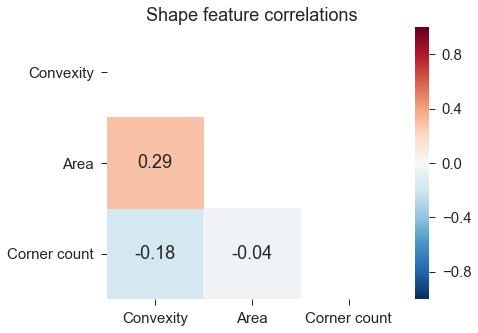

In [529]:
shape_labels = ['Corner count', 'Area', 'Convexity']

mask_shape = np.zeros_like(shape_corr, dtype=np.bool)
mask_shape[np.triu_indices_from(mask_shape)] = True

plt.figure(figsize=(6.5,5))
sns.heatmap(shape_corr, annot=True, mask=mask_shape)

plt.yticks(np.array([0,1,2])+.5, shape_labels, rotation=0)
plt.xticks(np.array([0,1,2])+.5, shape_labels[::-1])

plt.title("Shape feature correlations")

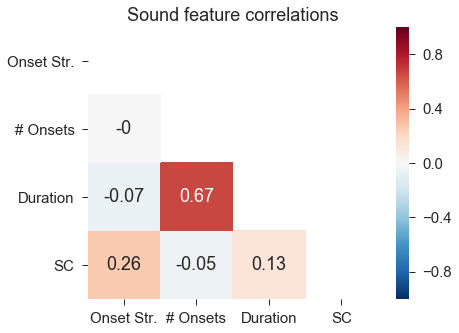

In [528]:
sound_labels = ['SC', 'Duration', '# Onsets', 'Onset Str.']

mask_sound = np.zeros_like(sound_corr, dtype=np.bool)
mask_sound[np.triu_indices_from(mask_sound)] = True

plt.figure(figsize=(6.5,5))
sns.heatmap(sound_corr.round(2), annot=True, mask=mask_sound)

plt.yticks(np.array([0,1,2,3])+.5, sound_labels, rotation=0)
plt.xticks(np.array([0,1,2,3])+.5, sound_labels[::-1])

plt.title("Sound feature correlations")

## Hierarchical Bayesian models

### Set model fitting parameters

In [463]:
samples = 1500
chains = 4
n_splits = 5

### Multimodal

Fit a single model including sounds and images with both positve and negative emotions. Include modality and valence conditions as predictors. Allow participants' slopes and intercepts to vary.

In [17]:
fold_data_big = bambi_cv(
    merged, 
    model_string = 'highArousal ~ bin*modalitySound*positiveValence', 
    model_dict = {
        'random': ['bin*modalitySound*positiveValence|subID'],
        'categorical': ['subID', 'modalitySound', 'positiveValence'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to modalitySound
Assigned NUTS to positiveValence
Assigned NUTS to modalitySound:positiveValence
Assigned NUTS to bin
Assigned NUTS to bin:modalitySound
Assigned NUTS to bin:positiveValence
Assigned NUTS to bin:modalitySound:positiveValence
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to modalitySound[T.True]|subID_sd_log__
Assigned NUTS to modalitySound[T.True]|subID_offset
Assigned NUTS to positiveValence[T.True]|subID_sd_log__
Assigned NUTS to positiveValence[T.True]|subID_offset
Assigned NUTS to modalitySou

100%|██████████| 2000/2000 [15:26<00:00,  2.16it/s]


In [117]:
np.mean(fold_data_big[0])

0.78390289961515669

In [118]:
np.std(fold_data_big[0])

0.0008056506350105952

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


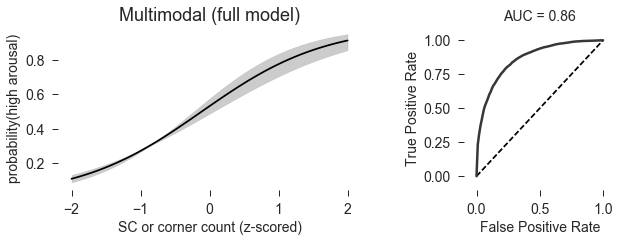

In [163]:
plot_full_cv(
    fold_data_big[1], fold_data_big[3], 'bin', merged, 
    x_label="SC or corner count (z-scored)", y_label="probability(high arousal)", title="Multimodal (full model)"
)

In [209]:
print(summary_table(fold_data_big[1]))

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


|                                                            |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-----------------------------------------------------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd                                                 | 0.36 | 0.08 |       0.22 |       0.52 |        1234.4 |              1 |
| Intercept                                                  | 0.13 | 0.09 |      -0.05 |       0.31 |        2090.4 |              1 |
| bin                                                        | 1.12 | 0.1  |       0.92 |       1.32 |        1760   |              1 |
| bin:modalitySound                                  | 0.69 | 0.15 |       0.4  |       1    |        2337.6 |              1 |
| bin:modalitySound:positiveValence          | 0.04 | 0.28 |      -0.49 |       0.6  |        3094.8 |              1 |
| bin:modalitySound:positiveValence\\subID_sd | 0.64 | 0.3  |       0.0

In [18]:
fold_data_big_bin = bambi_cv(
    merged, 
    model_string = 'highArousal ~ bin', 
    model_dict = {
        'random': ['bin|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
100%|██████████| 2000/2000 [02:14<00:00, 14.85it/s]
/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  sel

In [119]:
np.mean(fold_data_big_bin[0])

0.77411937021699306

In [120]:
np.std(fold_data_big_bin[0])

0.0055272825511406701

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


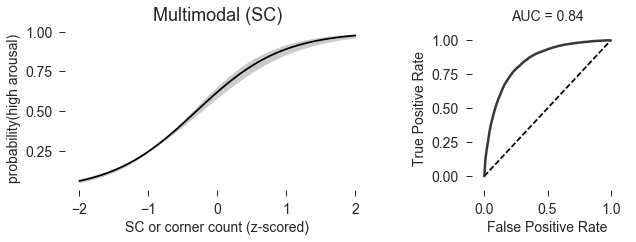

In [462]:
plot_full_cv(
    fold_data_big_bin[1], fold_data_big_bin[3], 'bin', merged, 
    x_label="SC or corner count (z-scored)", y_label="probability(high arousal)", title="Multimodal (SC)"
)

In [210]:
print(summary_table(fold_data_big_bin[1]))

|              |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd   | 0.45 | 0.06 |       0.35 |       0.57 |        1348   |              1 |
| Intercept    | 0.49 | 0.08 |       0.34 |       0.64 |         904.6 |              1 |
| bin          | 1.61 | 0.08 |       1.45 |       1.77 |        1160.4 |              1 |
| bin\\subID_sd | 0.47 | 0.06 |       0.36 |       0.6  |        1584   |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


In [32]:
fold_data_big_modality = bambi_cv(
    merged, 
    model_string = 'highArousal ~ modalitySound', 
    model_dict = {
        'random': ['modalitySound|subID'],
        'categorical': ['subID', 'modalitySound'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to modalitySound
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to modalitySound[T.True]|subID_sd_log__
Assigned NUTS to modalitySound[T.True]|subID_offset
100%|██████████| 2000/2000 [07:56<00:00,  4.20it/s]
Assigned NUTS to Intercept
Assigned NUTS to modalitySound
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to modalitySound[T.True]|subID_sd_log__
Assigned NUTS to modalitySound[T.True]|subID_offset
100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Assigned NUTS to Intercept
A

In [121]:
np.mean(fold_data_big_modality[0])

0.58006114260030861

In [122]:
np.std(fold_data_big_modality[0])

0.011943021260093558

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


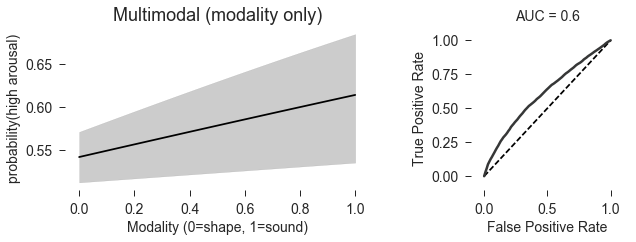

In [165]:
plot_full_cv(
    fold_data_big_modality[1], fold_data_big_modality[3], 'modalitySound', merged, 
    x_label="Modality (0=shape, 1=sound)", y_label="probability(high arousal)", title="Multimodal (modality only)"
)

In [211]:
print(summary_table(fold_data_big_modality[1]))

|                                |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------------------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd                     | 0.35 | 0.05 |       0.26 |       0.44 |        2706   |              1 |
| Intercept                      | 0.17 | 0.06 |       0.05 |       0.29 |        4675.4 |              1 |
| modalitySound          | 0.3  | 0.1  |       0.09 |       0.49 |        4083.4 |              1 |
| modalitySound\\subID_sd | 0.6  | 0.08 |       0.45 |       0.76 |        2652.8 |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


In [35]:
fold_data_big_valence = bambi_cv(
    merged, 
    model_string = 'highArousal ~ positiveValence', 
    model_dict = {
        'random': ['positiveValence|subID'],
        'categorical': ['subID', 'positiveValence'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to positiveValence
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to positiveValence[T.True]|subID_sd_log__
Assigned NUTS to positiveValence[T.True]|subID_offset
 94%|█████████▍| 1883/2000 [03:59<00:14,  7.85it/s]/usr/local/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.665354735274, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/loc

Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to positiveValence[T.True]|subID_sd_log__
Assigned NUTS to positiveValence[T.True]|subID_offset
 95%|█████████▌| 1909/2000 [03:41<00:10,  8.62it/s]/usr/local/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 2 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 1998/2000 [03:49<00:00,  8.71it/s]/usr/local/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.671813623031, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 31 diverging samples after tuning. If increasing `target_accept` does not help 

In [123]:
np.mean(fold_data_big_valence[0])

0.57111944408405368

In [124]:
np.std(fold_data_big_valence[0])

0.0035552385094042589

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


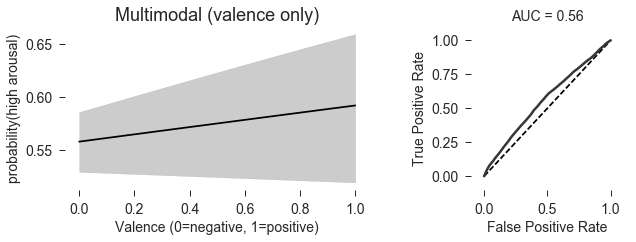

In [166]:
plot_full_cv(
    fold_data_big_valence[1], fold_data_big_valence[3], 'positiveValence', merged, 
    x_label="Valence (0=negative, 1=positive)", y_label="probability(high arousal)", title="Multimodal (valence only)"
)

In [212]:
print(summary_table(fold_data_big_valence[1]))

|                                  |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:---------------------------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd                       | 0.24 | 0.04 |       0.16 |       0.32 |        1177.6 |              1 |
| Intercept                        | 0.23 | 0.06 |       0.12 |       0.35 |         955.2 |              1 |
| positiveValence          | 0.14 | 0.09 |      -0.04 |       0.31 |        1158.4 |              1 |
| positiveValence\\subID_sd | 0.13 | 0.09 |       0    |       0.28 |         476   |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


### Vision

In [ ]:
vis.head()

In [36]:
fold_data_vis = bambi_cv(
    vis, 
    model_string = 'highArousal ~ bin*areaRatio*boundingBoxArea', 
    model_dict = {
        'random': ['bin*areaRatio*boundingBoxArea|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to areaRatio
Assigned NUTS to bin:areaRatio
Assigned NUTS to boundingBoxArea
Assigned NUTS to bin:boundingBoxArea
Assigned NUTS to areaRatio:boundingBoxArea
Assigned NUTS to bin:areaRatio:boundingBoxArea
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
Assigned NUTS to areaRatio|subID_sd_log__
Assigned NUTS to areaRatio|subID_offset
Assigned NUTS to bin:areaRatio|subID_sd_log__
Assigned NUTS to bin:areaRatio|subID_offset
Assigned NUTS to b

In [125]:
np.mean(fold_data_vis[0])

0.8267083590127402

In [126]:
np.std(fold_data_vis[0])

0.0036794579362825187

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))


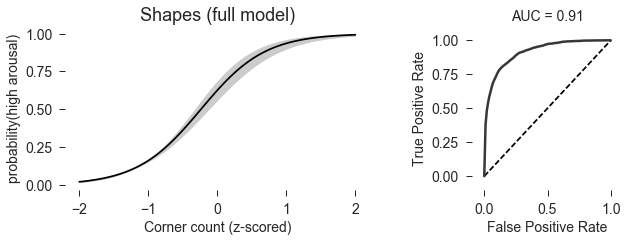

In [167]:
plot_full_cv(
    fold_data_vis[1], fold_data_vis[3], 'bin', vis, 
    x_label="Corner count (z-scored)", y_label="probability(high arousal)", title="Shapes (full model)"
)

In [213]:
print(summary_table(fold_data_vis[1]))

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))


|                                        |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:---------------------------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd                             |  0.82 | 0.11 |       0.62 |       1.05 |        2130.2 |              1 |
| Intercept                              |  0.51 | 0.14 |       0.24 |       0.78 |        1434.6 |              1 |
| areaRatio                              | -1.23 | 0.08 |      -1.39 |      -1.08 |        5048.4 |              1 |
| areaRatio:boundingBoxArea              | -0.41 | 0.06 |      -0.52 |      -0.3  |        6000   |              1 |
| areaRatio:boundingBoxArea\\subID_sd     |  0.11 | 0.07 |       0    |       0.24 |        2275.2 |              1 |
| areaRatio\\subID_sd                     |  0.35 | 0.07 |       0.22 |       0.48 |        2846.6 |              1 |
| bin                                    |  2.16 | 0.11 |    

In [79]:
fold_data_vis_bin = bambi_cv(
    vis, 
    model_string = 'highArousal ~ bin', 
    model_dict = {
        'random': ['bin|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
100%|██████████| 2000/2000 [01:48<00:00, 18.47it/s]
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
100%|██████████| 2000/2000 [01:41<00:00, 19.68it/s]
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assign

In [127]:
np.mean(fold_data_vis_bin[0])

0.75126283433346841

In [128]:
np.std(fold_data_vis_bin[0])

0.010560957919000073

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


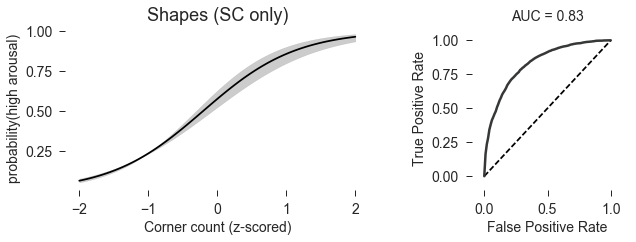

In [168]:
plot_full_cv(
    fold_data_vis_bin[1], fold_data_vis_bin[3], 'bin', vis, 
    x_label="Corner count (z-scored)", y_label="probability(high arousal)", title="Shapes (SC only)"
)

In [214]:
print(summary_table(fold_data_vis_bin[1]))

|              |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd   | 0.65 | 0.09 |       0.49 |       0.83 |        1550.8 |              1 |
| Intercept    | 0.31 | 0.11 |       0.1  |       0.52 |         816.6 |              1 |
| bin          | 1.48 | 0.1  |       1.28 |       1.68 |        1259.2 |              1 |
| bin\\subID_sd | 0.6  | 0.08 |       0.45 |       0.76 |        1608.2 |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


In [56]:
fold_data_vis_ratio = bambi_cv(
    vis, 
    model_string = 'highArousal ~ areaRatio', 
    model_dict = {
        'random': ['areaRatio|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to areaRatio
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to areaRatio|subID_sd_log__
Assigned NUTS to areaRatio|subID_offset
100%|██████████| 2000/2000 [01:15<00:00, 26.34it/s]
Assigned NUTS to Intercept
Assigned NUTS to areaRatio
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to areaRatio|subID_sd_log__
Assigned NUTS to areaRatio|subID_offset
100%|██████████| 2000/2000 [01:36<00:00, 20.73it/s]
Assigned NUTS to Intercept
Assigned NUTS to areaRatio
Assigned NUTS to 1|subID_sd_lo

In [129]:
np.mean(fold_data_vis_ratio[0])

0.68089762587582769

In [131]:
np.std(fold_data_vis_ratio[0])

0.010273151449256855

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


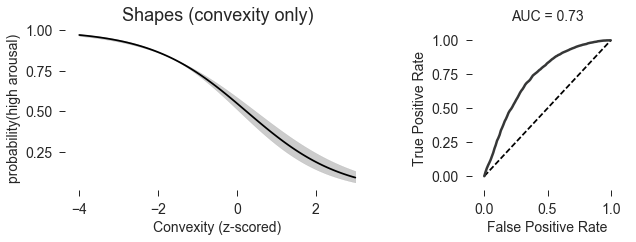

In [169]:
plot_full_cv(
    fold_data_vis_ratio[1], fold_data_vis_ratio[3], 'areaRatio', vis, 
    x_label="Convexity (z-scored)", y_label="probability(high arousal)", title="Shapes (convexity only)"
)

In [215]:
print(summary_table(fold_data_vis_ratio[1]))

|                    |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd         |  0.46 | 0.06 |       0.34 |       0.58 |        1924.2 |              1 |
| Intercept          |  0.2  | 0.08 |       0.05 |       0.35 |        2061   |              1 |
| areaRatio          | -0.83 | 0.05 |      -0.92 |      -0.74 |        4575.4 |              1 |
| areaRatio\\subID_sd |  0.22 | 0.05 |       0.13 |       0.31 |        2295   |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))


In [57]:
fold_data_vis_area = bambi_cv(
    vis, 
    model_string = 'highArousal ~ boundingBoxArea', 
    model_dict = {
        'random': ['boundingBoxArea|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='True'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to boundingBoxArea
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to boundingBoxArea|subID_sd_log__
Assigned NUTS to boundingBoxArea|subID_offset
100%|██████████| 2000/2000 [01:19<00:00, 25.04it/s]
Assigned NUTS to Intercept
Assigned NUTS to boundingBoxArea
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to boundingBoxArea|subID_sd_log__
Assigned NUTS to boundingBoxArea|subID_offset
100%|██████████| 2000/2000 [01:43<00:00, 19.38it/s]
Assigned NUTS to Intercept
Assigned NUTS to boun

In [132]:
np.mean(fold_data_vis_area[0])

0.61063717949530072

In [133]:
np.std(fold_data_vis_area[0])

0.013264343727354879

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))


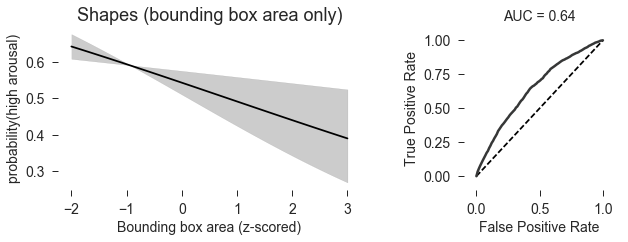

In [170]:
plot_full_cv(
    fold_data_vis_area[1], fold_data_vis_area[3], 'boundingBoxArea', vis, 
    x_label="Bounding box area (z-scored)", y_label="probability(high arousal)", title="Shapes (bounding box area only)"
)

In [216]:
print(summary_table(fold_data_vis_area[1]))

|                          |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd               |  0.39 | 0.05 |       0.29 |       0.49 |        2055   |              1 |
| Intercept                |  0.17 | 0.07 |       0.04 |       0.3  |        2084.4 |              1 |
| boundingBoxArea          | -0.21 | 0.07 |      -0.35 |      -0.07 |        2117.2 |              1 |
| boundingBoxArea\\subID_sd |  0.41 | 0.06 |       0.31 |       0.53 |        1766.6 |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='False'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='True'
  str(self.model.data[self.model.y.name][event])))


### Audition

In [ ]:
aud.head()

In [58]:
fold_data_aud = bambi_cv(
    aud, 
    model_string = 'highArousal ~ bin*duration*numOnsets*onsetStrength', 
    model_dict = {
        'random': ['bin*duration*numOnsets*onsetStrength|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='1'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to duration
Assigned NUTS to bin:duration
Assigned NUTS to numOnsets
Assigned NUTS to bin:numOnsets
Assigned NUTS to duration:numOnsets
Assigned NUTS to bin:duration:numOnsets
Assigned NUTS to onsetStrength
Assigned NUTS to bin:onsetStrength
Assigned NUTS to duration:onsetStrength
Assigned NUTS to bin:duration:onsetStrength
Assigned NUTS to numOnsets:onsetStrength
Assigned NUTS to bin:numOnsets:onsetStrength
Assigned NUTS to duration:numOnsets:onsetStrength
Assigned NUTS to bin:duration:numOnsets:onsetStrength
Assigned NUTS to 

Assigned NUTS to duration|subID_offset
Assigned NUTS to bin:duration|subID_sd_log__
Assigned NUTS to bin:duration|subID_offset
Assigned NUTS to numOnsets|subID_sd_log__
Assigned NUTS to numOnsets|subID_offset
Assigned NUTS to bin:numOnsets|subID_sd_log__
Assigned NUTS to bin:numOnsets|subID_offset
Assigned NUTS to duration:numOnsets|subID_sd_log__
Assigned NUTS to duration:numOnsets|subID_offset
Assigned NUTS to bin:duration:numOnsets|subID_sd_log__
Assigned NUTS to bin:duration:numOnsets|subID_offset
Assigned NUTS to onsetStrength|subID_sd_log__
Assigned NUTS to onsetStrength|subID_offset
Assigned NUTS to bin:onsetStrength|subID_sd_log__
Assigned NUTS to bin:onsetStrength|subID_offset
Assigned NUTS to duration:onsetStrength|subID_sd_log__
Assigned NUTS to duration:onsetStrength|subID_offset
Assigned NUTS to bin:duration:onsetStrength|subID_sd_log__
Assigned NUTS to bin:duration:onsetStrength|subID_offset
Assigned NUTS to numOnsets:onsetStrength|subID_sd_log__
Assigned NUTS to numOnset

In [134]:
np.mean(fold_data_aud[0])

0.83252379505602736

In [135]:
np.std(fold_data_aud[0])

0.0078066410138228279

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


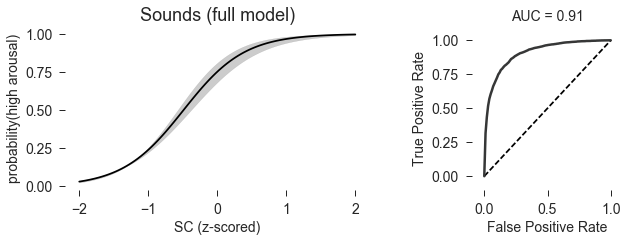

In [171]:
plot_full_cv(
    fold_data_aud[1], fold_data_aud[3], 'bin', aud, 
    x_label="SC (z-scored)", y_label="probability(high arousal)", title="Sounds (full model)"
)

In [217]:
print(summary_table(fold_data_aud[1]))

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


|                                               |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:----------------------------------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd                                    |  1.01 | 0.13 |       0.77 |       1.28 |        1422.8 |              1 |
| Intercept                                     |  1.11 | 0.17 |       0.77 |       1.45 |         708   |              1 |
| bin                                           |  2.26 | 0.13 |       2.01 |       2.52 |        1836.2 |              1 |
| bin:duration                                  | -0.33 | 0.1  |      -0.51 |      -0.14 |        3030   |              1 |
| bin:duration:numOnsets                        | -0.07 | 0.07 |      -0.2  |       0.07 |        4673.8 |              1 |
| bin:duration:numOnsets:onsetStrength          | -0.16 | 0.08 |      -0.32 |       0    |        4707.6 |              1 |
| bin:d

In [59]:
fold_data_aud_bin = bambi_cv(
    aud, 
    model_string = 'highArousal ~ bin', 
    model_dict = {
        'random': ['bin|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='1'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
100%|██████████| 2000/2000 [01:54<00:00, 17.40it/s]
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to bin|subID_sd_log__
Assigned NUTS to bin|subID_offset
100%|██████████| 2000/2000 [01:54<00:00, 17.44it/s]
Assigned NUTS to Intercept
Assigned NUTS to bin
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned 

In [136]:
np.mean(fold_data_aud_bin[0])

0.81602343970778557

In [137]:
np.std(fold_data_aud_bin[0])

0.0078981354195811985

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


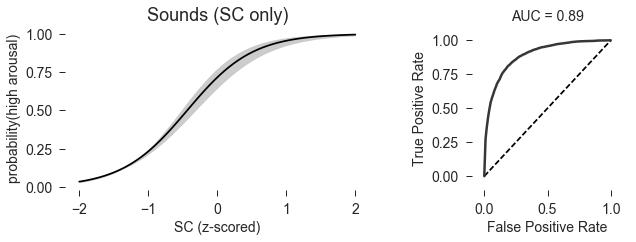

In [172]:
plot_full_cv(
    fold_data_aud_bin[1], fold_data_aud_bin[3], 'bin', aud, 
    x_label="SC (z-scored)", y_label="probability(high arousal)", title="Sounds (SC only)"
)

In [218]:
print(summary_table(fold_data_aud_bin[1]))

|              |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd   | 0.95 | 0.12 |       0.72 |       1.19 |         997.2 |              1 |
| Intercept    | 0.92 | 0.16 |       0.6  |       1.22 |         574.8 |              1 |
| bin          | 2.11 | 0.11 |       1.9  |       2.34 |        1237.4 |              1 |
| bin\\subID_sd | 0.63 | 0.09 |       0.46 |       0.81 |        1536   |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


In [60]:
fold_data_aud_duration = bambi_cv(
    aud, 
    model_string = 'highArousal ~ duration', 
    model_dict = {
        'random': ['duration|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='1'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to duration
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to duration|subID_sd_log__
Assigned NUTS to duration|subID_offset
100%|██████████| 2000/2000 [01:51<00:00, 17.94it/s]
Assigned NUTS to Intercept
Assigned NUTS to duration
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to duration|subID_sd_log__
Assigned NUTS to duration|subID_offset
100%|██████████| 2000/2000 [02:01<00:00, 16.40it/s]
Assigned NUTS to Intercept
Assigned NUTS to duration
Assigned NUTS to 1|subID_sd_log__
Assign

In [138]:
np.mean(fold_data_aud_duration[0])

0.60493710376824716

In [139]:
np.std(fold_data_aud_duration[0])

0.009252101314001452

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


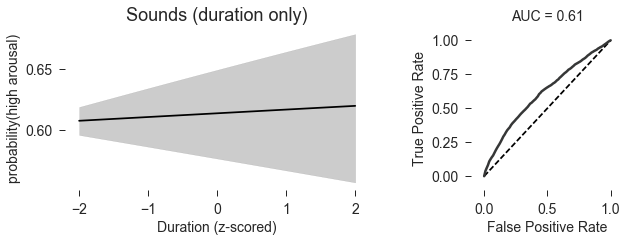

In [173]:
plot_full_cv(
    fold_data_aud_duration[1], fold_data_aud_duration[3], 'duration', aud, 
    x_label="Duration (z-scored)", y_label="probability(high arousal)", title="Sounds (duration only)"
)

In [219]:
print(summary_table(fold_data_aud_duration[1]))

|                   |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:------------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd        | 0.46 | 0.06 |       0.35 |       0.58 |        1477.4 |              1 |
| Intercept         | 0.46 | 0.08 |       0.31 |       0.62 |        1129.6 |              1 |
| duration          | 0.01 | 0.03 |      -0.04 |       0.07 |        5979.2 |              1 |
| duration\\subID_sd | 0.07 | 0.04 |       0    |       0.14 |        1512.4 |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


In [81]:
fold_data_aud_onsets = bambi_cv(
    aud, 
    model_string = 'highArousal ~ numOnsets', 
    model_dict = {
        'random': ['numOnsets|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='1'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to numOnsets
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to numOnsets|subID_sd_log__
Assigned NUTS to numOnsets|subID_offset
100%|██████████| 2000/2000 [01:47<00:00, 18.60it/s]
Assigned NUTS to Intercept
Assigned NUTS to numOnsets
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to numOnsets|subID_sd_log__
Assigned NUTS to numOnsets|subID_offset
100%|██████████| 2000/2000 [02:03<00:00, 16.24it/s]
Assigned NUTS to Intercept
Assigned NUTS to numOnsets
Assigned NUTS to 1|subID_sd_log__

In [140]:
np.mean(fold_data_aud_onsets[0])

0.60094428178397419

In [141]:
np.std(fold_data_aud_onsets[0])

0.0059687233461077696

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


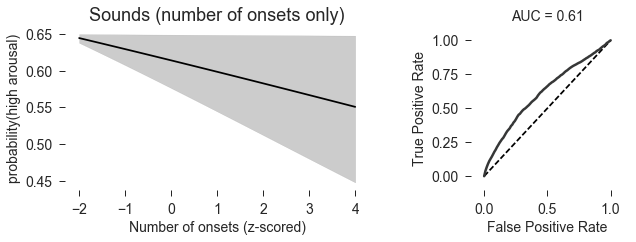

In [174]:
plot_full_cv(
    fold_data_aud_onsets[1], fold_data_aud_onsets[3], 'numOnsets', aud, 
    x_label="Number of onsets (z-scored)", y_label="probability(high arousal)", title="Sounds (number of onsets only)"
)

In [220]:
print(summary_table(fold_data_aud_onsets[1]))

|                    |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd         |  0.46 | 0.06 |       0.35 |       0.59 |        1631.8 |              1 |
| Intercept          |  0.47 | 0.08 |       0.31 |       0.62 |        1364.2 |              1 |
| numOnsets          | -0.07 | 0.03 |      -0.13 |      -0    |        5580.8 |              1 |
| numOnsets\\subID_sd |  0.13 | 0.04 |       0.05 |       0.21 |        1792.6 |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


In [62]:
fold_data_aud_strength = bambi_cv(
    aud, 
    model_string = 'highArousal ~ onsetStrength', 
    model_dict = {
        'random': ['onsetStrength|subID'],
        'categorical': ['subID'],
        'family': 'bernoulli', 
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits
)

/usr/local/lib/python3.6/site-packages/bambi/models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/usr/local/lib/python3.6/site-packages/bambi/models.py:219: UserWarning: Modeling the probability that highArousal=='1'
  self.y.name, str(self.data[self.y.name].iloc[event])))
Assigned NUTS to Intercept
Assigned NUTS to onsetStrength
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to onsetStrength|subID_sd_log__
Assigned NUTS to onsetStrength|subID_offset
100%|██████████| 2000/2000 [02:11<00:00, 15.18it/s]
Assigned NUTS to Intercept
Assigned NUTS to onsetStrength
Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
Assigned NUTS to onsetStrength|subID_sd_log__
Assigned NUTS to onsetStrength|subID_offset
100%|██████████| 2000/2000 [02:32<00:00, 13.11it/s]
Assigned NUTS to Intercept
Assigned NUTS to onsetStrength
Assig

In [142]:
np.mean(fold_data_aud_strength[0])

0.63903202853913077

In [143]:
np.std(fold_data_aud_strength[0])

0.0069409549527272114

/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


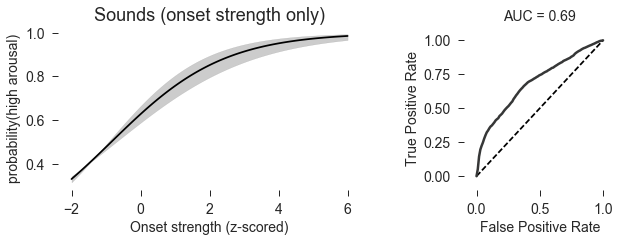

In [175]:
plot_full_cv(
    fold_data_aud_strength[1], fold_data_aud_strength[3], 'onsetStrength', aud, 
    x_label="Onset strength (z-scored)", y_label="probability(high arousal)", title="Sounds (onset strength only)"
)

In [221]:
print(summary_table(fold_data_aud_strength[1]))

|                        |    M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-----------------------|-----:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\\subID_sd             | 0.49 | 0.07 |       0.37 |       0.63 |        1818.2 |              1 |
| Intercept              | 0.52 | 0.08 |       0.36 |       0.68 |        1582.2 |              1 |
| onsetStrength          | 0.61 | 0.06 |       0.5  |       0.73 |        3301   |              1 |
| onsetStrength\\subID_sd | 0.31 | 0.05 |       0.22 |       0.41 |        2463   |              1 |


/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='1'
  str(self.model.data[self.model.y.name][event])))
/usr/local/lib/python3.6/site-packages/bambi/results.py:355: UserWarning: Modeling the probability that highArousal=='0'
  str(self.model.data[self.model.y.name][event])))


## Model accuracy summaries

In [415]:
import itertools

In [374]:
multimodal = [
    fold_data_big,
    fold_data_big_bin,
    fold_data_big_modality,
    fold_data_big_valence
]
shapes = [
    fold_data_vis,
    fold_data_vis_bin,
    fold_data_vis_ratio,
    fold_data_vis_area
]
sounds = [
    fold_data_aud,
    fold_data_aud_bin,
    fold_data_aud_strength,
    fold_data_aud_duration,
    fold_data_aud_onsets
]

In [427]:
summary_df = pd.DataFrame({
    'Model': (
        ['Multimodal, full'] * 5 + 
        ['Multimodal, SC'] * 5 + 
        ['Multimodal, modality'] * 5 + 
        ['Multimodal, valence'] * 5
    ),
    'Modality': ['Multimodal'] * 4 * 5,
    'Accuracy': list(itertools.chain.from_iterable([fd[0] for fd in multimodal])),
    'AUC': list(itertools.chain.from_iterable([fd[4] for fd in multimodal]))
}).append(pd.DataFrame({
    'Model': (
        ['Shapes, full'] * 5 + 
        ['Shapes, corner count'] * 5 + 
        ['Shapes, convexity'] * 5 + 
        ['Shapes, area'] * 5
    ),
    'Modality': ['Shapes'] * 4 * 5,
    'Accuracy': list(itertools.chain.from_iterable([fd[0] for fd in shapes])),
    'AUC': list(itertools.chain.from_iterable([fd[4] for fd in shapes]))
})).append(pd.DataFrame({
    'Model': (
        ['Sounds, full'] * 5 + 
        ['Sounds, SC'] * 5 + 
        ['Sounds, mean onset strength'] * 5 + 
        ['Sounds, # onsets'] * 5 + 
        ['Sounds, duration'] * 5
    ),
    'Modality': ['Sounds'] * 5 * 5,
    'Accuracy': list(itertools.chain.from_iterable([fd[0] for fd in sounds])),
    'AUC': list(itertools.chain.from_iterable([fd[4] for fd in sounds]))
}))

In [428]:
summary_df.head().round(2)

,AUC,Accuracy,Modality,Model
0,0.86,0.78,Multimodal,"Multimodal, full"
1,0.86,0.78,Multimodal,"Multimodal, full"
2,0.86,0.79,Multimodal,"Multimodal, full"
3,0.86,0.78,Multimodal,"Multimodal, full"
4,0.86,0.78,Multimodal,"Multimodal, full"


In [450]:
chance_merged = (merged['highArousal'].value_counts() / merged.shape[0]).max()
chance_vis = (vis['highArousal'].value_counts() / vis.shape[0]).max()
chance_aud = (aud['highArousal'].value_counts() / aud.shape[0]).max()

In [451]:
chance_merged

0.57213448802852773

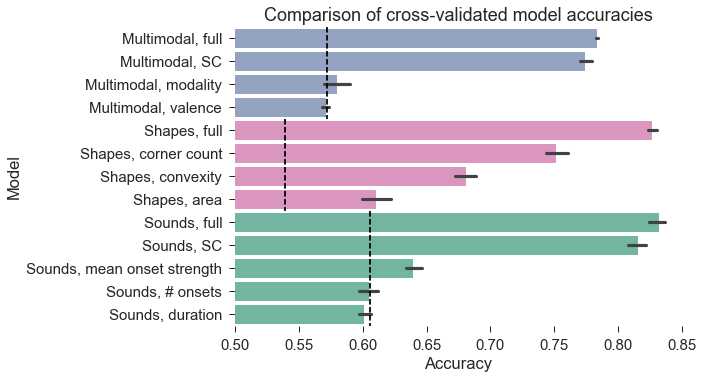

In [461]:
sns.set_context('notebook', font_scale=1.5)
colors = sns.color_palette("Set2", 10)
g = sns.barplot(
    y='Model', 
    x='Accuracy', 
    palette=[colors[2]] * 4 + [colors[3]] * 4 + [colors[0]] * 5,
    orient='h',
    data=summary_df
)
plt.plot([chance_merged] * 2, [-.5, 3.5], '--', c='black')
plt.plot([chance_vis] * 2, [3.5, 7.5], '--', c='black')
plt.plot([chance_aud] * 2, [7.5, 13.5], '--', c='black')

plt.xlim((0.5, .85))
plt.xlabel("Accuracy")
plt.title("Comparison of cross-validated model accuracies")
sns.despine(left=True, bottom=True)

## Model comparison using LOO information criterion

In [ ]:
traces_aud = [
    model_aud.backend.trace,
    model_aud_bin.backend.trace,
    model_aud_duration.backend.trace,
    model_aud_onsets.backend.trace,
    model_aud_strength.backend.trace
]
models_aud = [
    model_aud.backend.model,
    model_aud_bin.backend.model,
    model_aud_duration.backend.model,
    model_aud_onsets.backend.model,
    model_aud_strength.backend.model
]
compare_aud = pm.compare(traces_aud, models_aud, ic='LOO')
compare_aud

## Posterior predictive check, cross-validated

In [253]:
def ppc_cv(models, source_df, param='highArousal'):
    fold_ppc = []
    fold_ppc_mean = []
    fold_ppc_mean_sd = []
    fold_ppc_sd = []
    fold_ppc_sd_sd = []
    fold_test_mean = []
    fold_test_sd = []
    
    for model in models:
        test_data = source_df.drop(model.data.index, axis=0)
        ppc = pm.sample_ppc(
            model.backend.trace,
            samples=500,
            model=model.backend.model
        )
        
        fold_ppc.append(ppc)
        fold_ppc_mean.append(np.mean([n.mean() for n in ppc[param]]))
        fold_ppc_mean_sd.append(np.std([n.mean() for n in ppc[param]]))
        fold_ppc_sd.append(np.mean([n.std() for n in ppc[param]]))
        fold_ppc_sd_sd.append(np.std([n.std() for n in ppc[param]]))
        fold_test_mean.append(test_data[param].mean())
        fold_test_sd.append(test_data[param].std())
    
    return {
        'ppc': fold_ppc,
        'ppc_mean': np.array(fold_ppc_mean),
        'ppc_mean_sd': np.array(fold_ppc_mean_sd),
        'ppc_sd': np.array(fold_ppc_sd),
        'ppc_sd_sd': np.array(fold_ppc_sd_sd),
        'test_mean': np.array(fold_test_mean),
        'test_sd': np.array(fold_test_sd)
    }

In [254]:
def discrepancy_cv(ppc_dict):
    d_mean = np.mean(ppc_dict['ppc_mean'] - ppc_dict['test_mean'])
    d_sd = np.mean(ppc_dict['ppc_sd'] - ppc_dict['test_sd'])
    return (d_mean, d_sd)

In [257]:
ppc = ppc_cv(fold_data_aud_strength[2], aud)
discrepancy_cv(ppc)

100%|██████████| 500/500 [00:00<00:00, 566.83it/s]


(-5.0650175447053415e-05, -0.00014806437285647123)

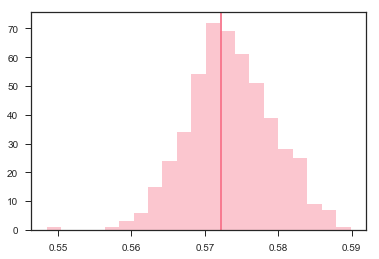

In [273]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc_big_valence['ppc'][0]['highArousal']], kde=False, ax=ax)
ax.axvline(merged['highArousal'].mean())